## Import Necessary Libraries

In [1]:
import re
import unicodedata
import nltk
import numpy as np
import pandas as pd
import spacy
from sklearn.cluster import DBSCAN
import datetime as dt
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lookups import Lookups
import calendar as cd
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Import the news data 
 
https://www.kaggle.com/datasets/notlucasp/financial-news-headlines

In [2]:
df1=pd.read_csv("/content/drive/MyDrive/NLP_Project/cnbc_headlines.csv")
df1.head()

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN,NaN,NaN
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."


In [3]:
df2=pd.read_csv("/content/drive/MyDrive/NLP_Project/guardian_headlines.csv")
df2.head()

,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
2,18-Jul-20,Five key areas Sunak must tackle to serve up e...
3,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,18-Jul-20,The Week in Patriarchy \n\n\n Bacardi's 'lad...


In [4]:
df3=pd.read_csv("/content/drive/MyDrive/NLP_Project/reuters_headlines.csv")
df3.head()

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...


## Cleaning NULL values

In [5]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)

In [6]:
df1['Time']=pd.to_datetime(df1['Time'])
df1['Time']=df1['Time'].dt.strftime("%Y-%m-%d")

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [8]:
df2['Time']=pd.to_datetime(df2['Time'])
df2['Time']=df2['Time'].dt.strftime("%Y-%m-%d")

In [9]:
df3['Time']=pd.to_datetime(df3['Time'])
df3['Time']=df3['Time'].dt.strftime("%Y-%m-%d")

In [10]:
df1['Time']

0       2020-07-17
1       2020-07-17
3       2020-07-17
4       2020-07-17
5       2020-07-16
           ...    
3075    2017-12-26
3076    2018-09-20
3077    2017-12-22
3078    2017-12-22
3079    2017-12-22
Name: Time, Length: 2800, dtype: object

In [11]:
df3['Time']

0        2020-07-18
1        2020-07-18
2        2020-07-18
3        2020-07-18
4        2020-07-17
            ...    
32765    2018-03-20
32766    2018-03-20
32767    2018-03-20
32768    2018-03-20
32769    2018-03-20
Name: Time, Length: 32770, dtype: object

In [12]:
import matplotlib.pyplot as plt

def articles_per_month(df, l):
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df["Headlines"].groupby([df["Time"].dt.year, df["Time"].dt.month]).count().plot(kind="bar")
    plt.title("Number of Articles per Month (%s)" %l)

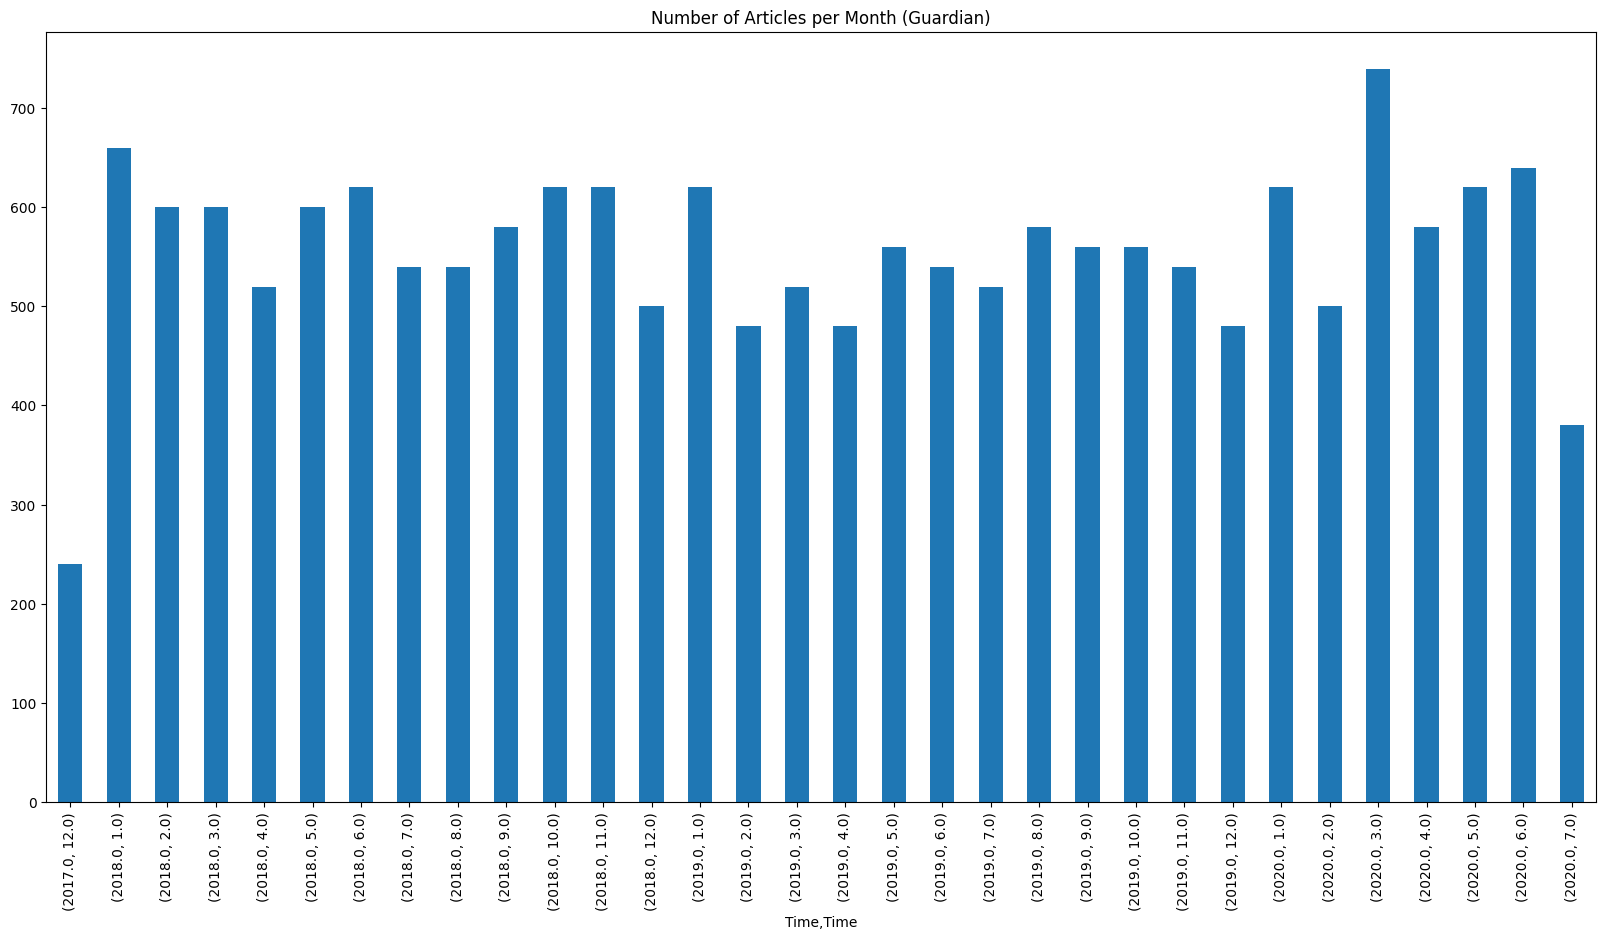

In [64]:
articles_per_month(df2, "Guardian")

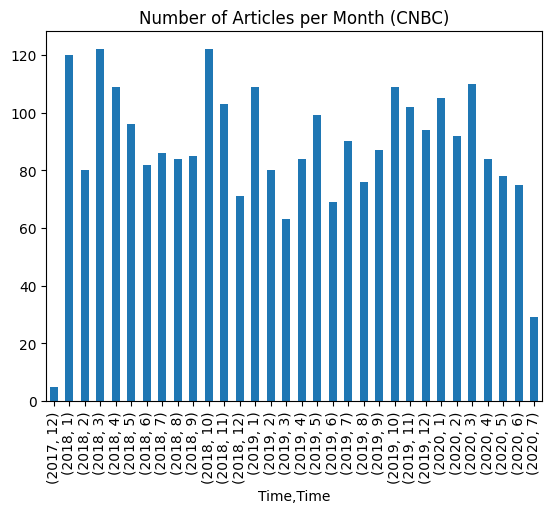

In [13]:
articles_per_month(df1, "CNBC")

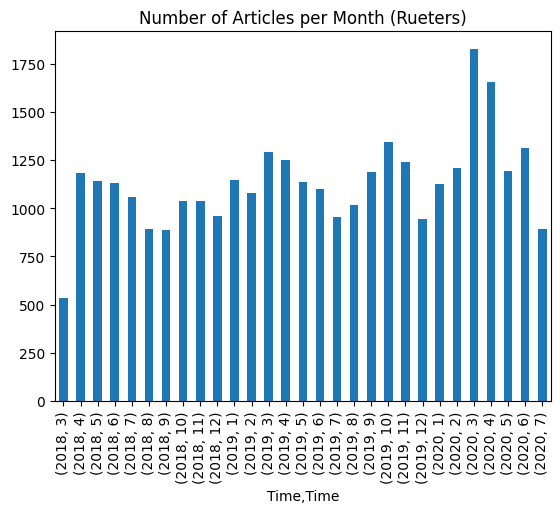

In [14]:
articles_per_month(df3, "Rueters")

In [15]:
remove_from_title = ["jim","cramer's week ahead:","cramer's lightning round:","cramer remix:","breaking:", "[\-:] report", "[\-:] sources",  "[\-:] source", "source says", "exclusive\:",
                         "factbox\:", "timeline[\-:]",  "instant view\:", "explainer\:", ": bloomberg",
                         ": wsj","[\:]","bloomberg","cnbc","reuters","thompson","wsj","source","cramer's lightning round:","jim cramer:","cramer","cramer","weeden",]

In [16]:
non_en_chars = {
        "’": "'",
        "‘": "'"
}

remove_if_start_with = ['close breaking news']
replace_if_contain = ['click here to see']

def replace_abbreviation(txt):
    words = {'U.S.': 'US','U.S.A.':'USA'}
    for w in words.keys():
        txt = re.sub(w, words[w], txt)
    return txt
def clean_text(raw_title):

    #Jim cramer: News then remove Jim cramer
    raw_title=raw_title.lower()
    
    text = replace_abbreviation(raw_title)
    for i in remove_from_title:
      text=re.sub(i,"",text)
    text=text.lower()
    
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove punctuation except hyphens and apostrophes
    text = re.sub(r"[^\w'-]+", " ", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)
    
    return text


In [17]:
title = "Facebook's Zuckerberg to testify before bloomberg Congress: source"
content = " jim Cramer's week ahead: Cramer's lightning round: Cramer Remix: The market may not be able to handle this perfect storm"

In [18]:
clean_text(content+title)

" the market may not be able to handle this perfect stormfacebook's zuckerberg to testify before congress"

## Install Yake for Keyword Extraction from the docs

In [19]:
!pip install yake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.8 MB/s eta 0:00:00


## Keyword Extraction

In [20]:
import yake
language = "en"
allow_types = ['PERSON', 'GPE', 'ORG', 'NORP', 'LOC', 'FAC', 'WORK_OF_ART', 'EVENT', 'LAW', 'PRODUCT']
def extract_keyword(text):
  
  text=clean_text(text)
  n_gram=1
  deduplication_threshold = 0.9
  numOfKeywords = 15

  custom_kw_extractor = yake.KeywordExtractor(lan=language, n=1, dedupLim=deduplication_threshold, top=15, features=None)
  keywords1 = custom_kw_extractor.extract_keywords(text) 

  custom_kw_extractor = yake.KeywordExtractor(lan=language, n=2, dedupLim=deduplication_threshold, top=10, features=None)
  keywords2 = custom_kw_extractor.extract_keywords(text) 

  custom_kw_extractor = yake.KeywordExtractor(lan=language, n=3, dedupLim=deduplication_threshold, top=5, features=None)
  keywords3 = custom_kw_extractor.extract_keywords(text) 

  keywords=[]
  weights=[]
#   #stemming
#   # Initialize Python porter stemmer
# ​
#   # Perform stemming
#   new_text=[]
#   for word in text:
#       new_text.append(stemmer.stem(word))


  
  for kw,wt in keywords1+keywords2+keywords3:
      keywords.append(kw)
      weights.append(wt)
  return " ".join(keywords)

    
   
    

In [21]:
extract_keyword(title + content)

'facebook storm zuckerberg testify congress market handle perfect facebook zuckerberg perfect storm facebook storm zuckerberg testify congress market handle perfect facebook zuckerberg perfect storm zuckerberg to testify testify before congress congress the market'

## Apply extract keywords in the dataframe

In [22]:
df1['keywords']=df1['Headlines']+"."+df1['Description']
df1['keywords']=df1['keywords'].apply(extract_keyword)

df1['keywords']




0       developers vaccine invest gold rush mad money ...
1       speed teradyne mad money host rings lightning ...
3       week earnings big bigger pay non-covid compani...
4       capital ceo keith bliss nasdaq tech healthcare...
5       wall kind advised street delivered pullback wa...
                              ...                        
3075    years markets christmas lack cheer kensho fare...
3076    taxes biggest mistake make market winnings rev...
3077    hand owning stocks cash set failure broke fewe...
3078    flash portfolios investors helped crash key ru...
3079    stock buy burned doubled key investing rule bu...
Name: keywords, Length: 2800, dtype: object

In [23]:
df1['keywords']

0       developers vaccine invest gold rush mad money ...
1       speed teradyne mad money host rings lightning ...
3       week earnings big bigger pay non-covid compani...
4       capital ceo keith bliss nasdaq tech healthcare...
5       wall kind advised street delivered pullback wa...
                              ...                        
3075    years markets christmas lack cheer kensho fare...
3076    taxes biggest mistake make market winnings rev...
3077    hand owning stocks cash set failure broke fewe...
3078    flash portfolios investors helped crash key ru...
3079    stock buy burned doubled key investing rule bu...
Name: keywords, Length: 2800, dtype: object

## Make Wordcloud of the most Frequent Words

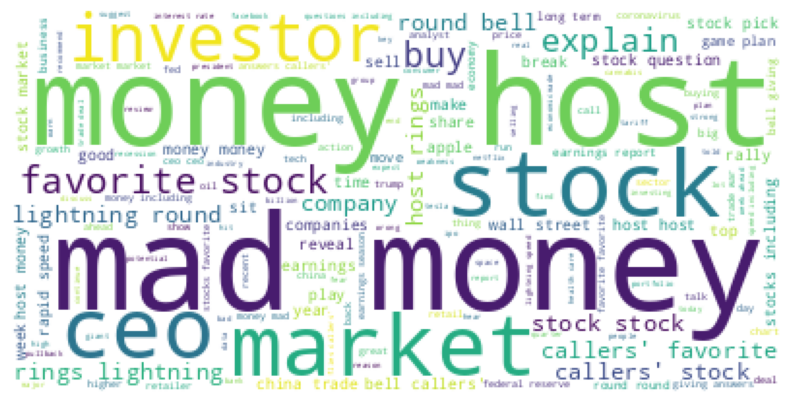

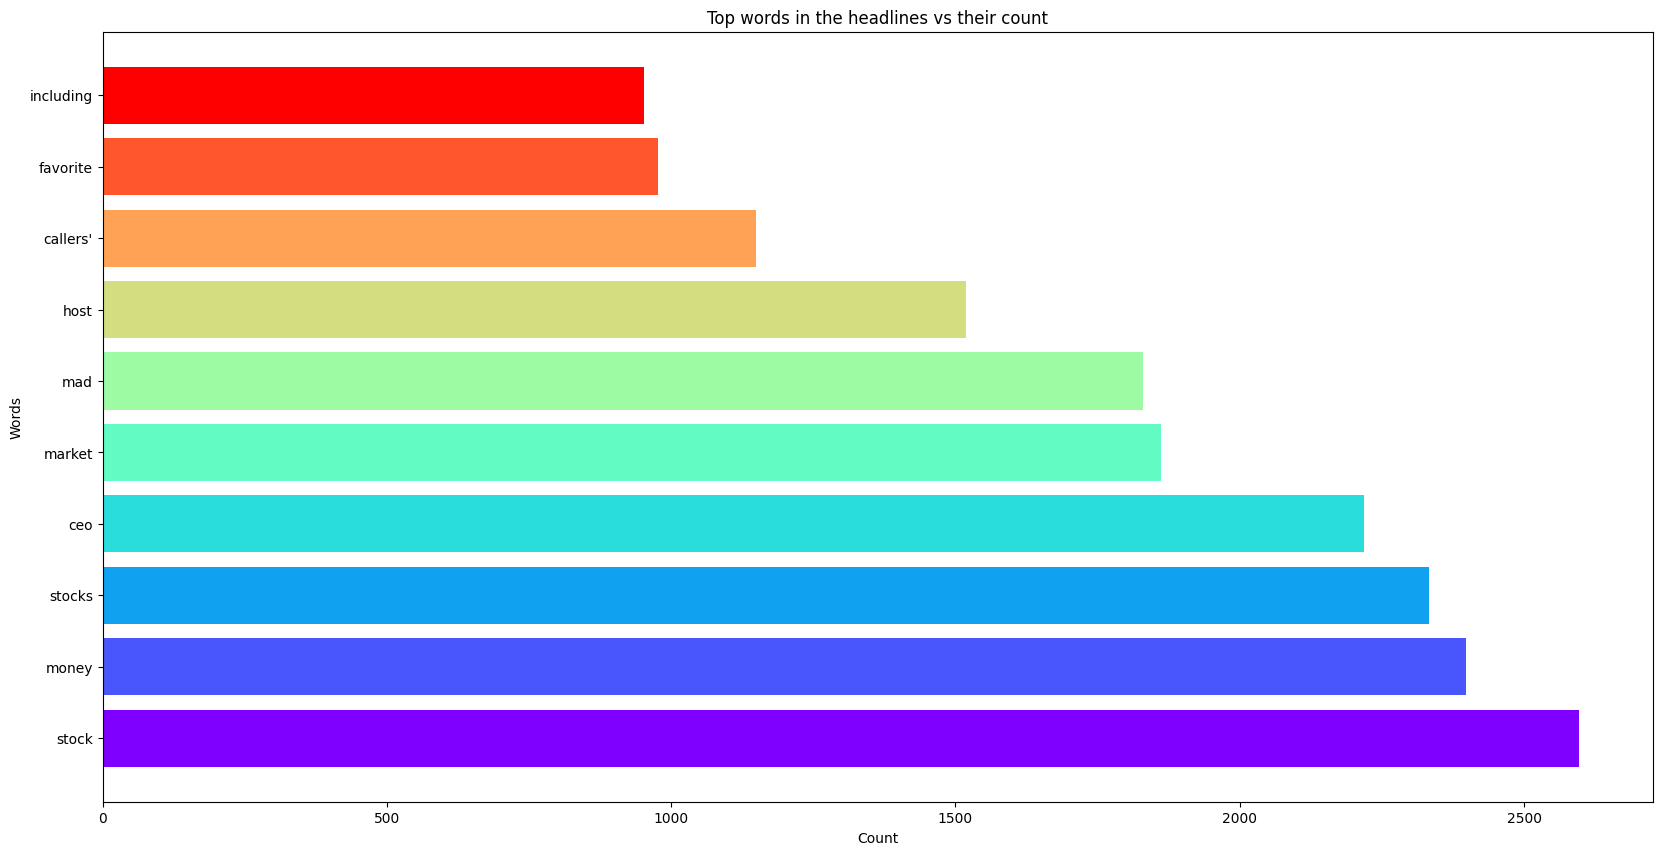

In [26]:
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
all_headlines = ""

for i in df1['keywords']:
    all_headlines+=i

stopwords = STOPWORDS
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(all_headlines)
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
filtered_words = [word for word in all_headlines.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)
words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10
plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
plt.show()

## Make new dataframe containing keywords (df4)

In [27]:
df1.to_csv("/content/drive/MyDrive/NLP_Project/new_df1.csv")

In [28]:
df4=pd.read_csv("/content/drive/MyDrive/NLP_Project/new_df1.csv")

In [29]:
df4

,Unnamed: 0,Headlines,Time,Description,keywords
0,0,Jim Cramer: A better way to invest in the Covi...,2020-07-17,"""Mad Money"" host Jim Cramer recommended buying...",developers vaccine invest gold rush mad money ...
1,1,Cramer's lightning round: I would own Teradyne,2020-07-17,"""Mad Money"" host Jim Cramer rings the lightnin...",speed teradyne mad money host rings lightning ...
2,3,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17,"""We'll pay more for the earnings of the non-Co...",week earnings big bigger pay non-covid compani...
3,4,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17,"Keith Bliss, IQ Capital CEO, joins ""Closing Be...",capital ceo keith bliss nasdaq tech healthcare...
4,5,Wall Street delivered the 'kind of pullback I'...,2020-07-16,"""Look for the stocks of high-quality companies...",wall kind advised street delivered pullback wa...
...,...,...,...,...,...
2795,3075,Markets lack Christmas cheer,2017-12-26,"According to Kensho, here's how markets have f...",years markets christmas lack cheer kensho fare...
2796,3076,Cramer Remix: The biggest mistake you can make...,2018-09-20,Jim Cramer revealed his top rule when it comes...,taxes biggest mistake make market winnings rev...
2797,3077,Cramer says owning too many stocks and too lit...,2017-12-22,Jim Cramer broke down why owning fewer stocks ...,hand owning stocks cash set failure broke fewe...
2798,3078,Cramer: I helped investors through the 2010 fl...,2017-12-22,"Jim Cramer built on his ""nobody ever made a di...",flash portfolios investors helped crash key ru...


In [30]:
df4['Time']=pd.to_datetime(df4['Time'])
df4['Time']=df4['Time'].dt.strftime("%Y-%m-%d")

# Convert the keywords into vectors (Vectorizaion)
##  using tf-idf vectorization technique

In [31]:
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer

texts = np.array(df4['keywords']) #text contents in dataframe to array for processing

vectorizer = TfidfVectorizer(ngram_range = (1,3), max_features = 250) #make Tfidf Vectorizer

tfidf_encodings = vectorizer.fit_transform(texts) #encode the text

In [32]:
tfidf_encodings.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.64929559, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [33]:
print(tfidf_encodings.shape)


(2800, 250)


## Finding Cosine Similarity b/w all the vectors

In [34]:
cos=cosine_similarity(tfidf_encodings)
cos

array([[1.        , 0.51788693, 0.04395492, ..., 0.08302127, 0.        ,
        0.04001455],
       [0.51788693, 1.        , 0.        , ..., 0.04751877, 0.        ,
        0.02720325],
       [0.04395492, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08302127, 0.04751877, 0.        , ..., 1.        , 0.09638725,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.09638725, 1.        ,
        0.49125349],
       [0.04001455, 0.02720325, 0.        , ..., 0.        , 0.49125349,
        1.        ]])

## Clustering using DBscan

In [35]:
from sklearn.cluster import DBSCAN


sim_mat = np.array(cos)
diff_mat = 1.0 - sim_mat
diff_mat[diff_mat < 0]=0

dbscan = DBSCAN(eps=3.75, min_samples=5)
dbscan.fit(diff_mat)

DBSCAN(eps=3.75)

In [36]:
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 14
Estimated number of noise points: 379


## Doing Hyperperparameter tuning and minimizing noise and maximizing the clusters

In [37]:
#minimizing the noise points by hyperparameter tuning
opt_eps,opt_mnsample=3.5,5
n_cls=0

for i in np.arange(0.5,4,0.5):
  for j in range(2,6):
    dbscan = DBSCAN(eps=i, min_samples=j)
    dbscan.fit(diff_mat)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if(n_cls < n_clusters_):
      noise=n_noise_
      opt_eps=i
      opt_mnsample=j



print(opt_eps,opt_mnsample)


3.5 5


In [38]:
Id={}
for i,j in zip(range(len(labels)),df1['Headlines']):
  Id[i]=j;


In [39]:
Id

{0: 'Jim Cramer: A better way to invest in the Covid-19 vaccine gold rush',
 1: "Cramer's lightning round: I would own Teradyne",
 2: "Cramer's week ahead: Big week for earnings, even bigger week for vaccines",
 3: 'IQ Capital CEO Keith Bliss says tech and healthcare will rally',
 4: "Wall Street delivered the 'kind of pullback I've been waiting for,' Jim Cramer says",
 5: "Cramer's lightning round: I would just stay long Wex",
 6: "Acorns CEO: Parents can turn $5 into five figures for their kids through 'power of compounding'",
 7: 'Dividend cuts may mean rethinking your retirement income strategy',
 8: 'StockX has authenticated 1 million Jordan sneakers this year, CEO says',
 9: 'Biohaven Pharmaceuticals lands Khloe Kardashian as influencer of new migraine drug',
 10: "Cramer's lightning round: I like Beyond Meat",
 11: 'Cramer: We desperately need another round of federal stimulus, despite vaccine progress',
 12: "Cramer's lightning round: Buy more VMware",
 13: "Wall Street did som

In [40]:
date={}
for i,j in zip(range(len(labels)),df1['Time']):
  date[i]=j;

In [41]:
content={}
for i,j in zip(range(len(labels)),df1['Description']):
  content[i]=j;

In [42]:
len(list(labels))

2800

In [43]:
# find Id of maximum size cluster which refers to the trending news

id=-1
sze=0
cnt=[]
for i in set(labels):
  cnt.append(list(labels).count(i))
  if(sze < list(labels).count(i) and i !=-1):
    sze=list(labels).count(i)

    id=i

print(id,sze)


1 1992


## Size of All clusters

In [44]:
cnt

[302, 1992, 19, 6, 4, 57, 4, 7, 7, 8, 3, 3, 5, 4, 379]

## Trending News Of the year 2019 and 2020

In [47]:
#Trending News have id=6
for i in range(len(labels)):
  if(labels[i]==np.argmax(cnt)):
    print(date[i],Id[i])




2020-07-17 00:00:00 IQ Capital CEO Keith Bliss says tech and healthcare will rally
2020-07-16 00:00:00 Acorns CEO: Parents can turn $5 into five figures for their kids through 'power of compounding'
2020-07-16 00:00:00 Dividend cuts may mean rethinking your retirement income strategy
2020-07-15 00:00:00 StockX has authenticated 1 million Jordan sneakers this year, CEO says
2020-07-15 00:00:00 Biohaven Pharmaceuticals lands Khloe Kardashian as influencer of new migraine drug
2020-07-14 00:00:00 Charts suggest the S&P 500 climb will stall out at the end of July, Jim Cramer warns
2020-07-13 00:00:00 Salesforce's Marc Benioff: Face masks can end the U.S. coronavirus crisis within weeks
2020-07-07 00:00:00 Stay invested in US markets for the next two years: Strategist
2020-07-06 00:00:00 DBS sees signs of a 'healthy' US market rally
2020-07-02 00:00:00 Aggressive policy bolstering markets: Hirtle Callaghan
2020-07-02 00:00:00 Sustainable produce supplier Apeel lands deal with Wakefern groce

## Map month number to month Name

In [48]:
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

## Plot of the Trending News Of The Month vs Count of Story Size

In [61]:
#fig, ax = plt.subplots(figsize=(15, 8))
def plot(yr,mon):
  # ax.clear()
  size=[]
  news=[]
  dat=[]
  for i in range(len(labels)):
      if(labels[i]==1 and date[i].month==mon and date[i].year==yr):
        news.append(Id[i])
        size.append(len(content[i]))
        dat.append(date[i].date())
     # print(date[i],Id[i])
  # Figure Size
  col=['#adb0ff', '#ffb3ff', '#90d595', '#e48381', '#aafbff', '#f7bb5f', '#eafb50']

  

  fig, ax = plt.subplots(figsize =(12, 9))
  ax.barh(news, size,color=col)

  for i,(j,k) in enumerate(zip(size,dat)):
      ax.text(j,i,k,ha="right")
  
 
  # Add Plot Title
  ax.set_title(month_dict[mon]+" "+str(yr),
             loc ='center',fontweight="bold",size=25 )
  #ax.text(1, 0.4, yr, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
 
  # # Add Text watermark
  plt.xlabel("Count of Story Size")
  fig.text(0.85, 0.15, '@souravdey', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
  # Show Plot
  plt.show()

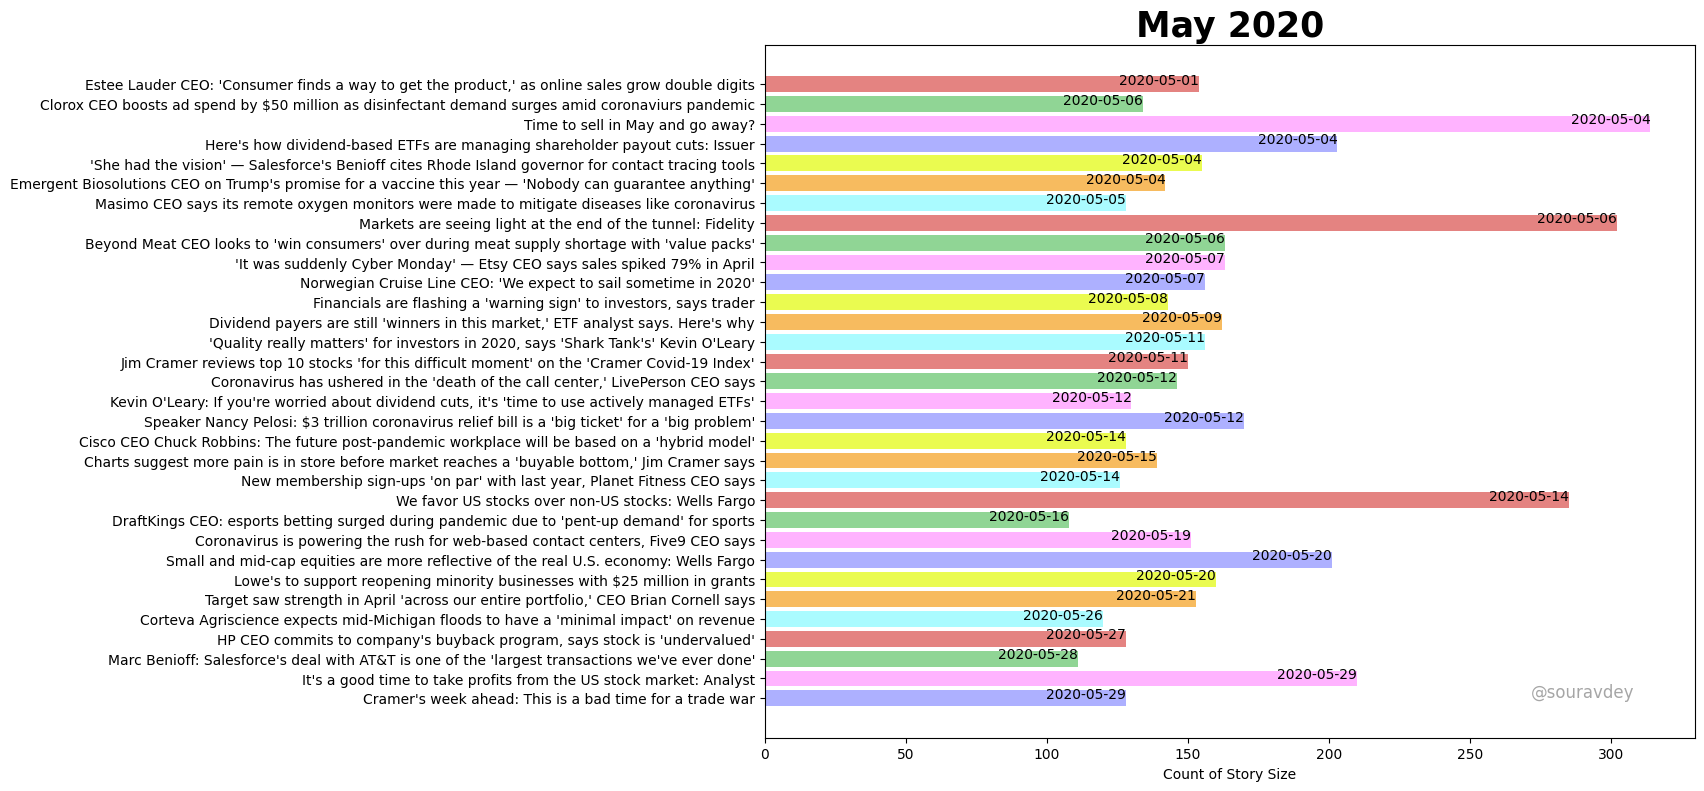

In [62]:
plot(2020,5)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
frame=[]
for i in range(4,13):
  frame.append((2019,i))
for i in range(1,8):
  frame.append((2020,i))

leng=len(frame)
def animate(i):
  ax.clear()
  plot(frame[i][0],frame[i][1])




fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, animate, frames=range(1,leng))
HTML(animator.to_jshtml()) 
animator.save("hello.mp4",fps=1.0, dpi=200)

